##Acknowledgement

The original coding is adapted from Github and re-arranged it so that ML flow is implemented for Cloud AI Coursework 2, Individual project. So, all the credits shall go to the initial developer.

## The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM Classifier
* Implement a sliding-window and Hog-Subsampling technique and use trained classifier to search for vehicles in images.
* Run the pipeline on a video stream (project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
* Apply ML flow for saving and loading the developed model

##Downloading MLflow (New code by NuwanJ)

In [ ]:
!pip install mlflow

##Call for required libraries

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle
# Newly added for this work by NuwanJ
import mlflow
import mlflow.sklearn
import seaborn as sns
from sklearn.metrics import classification_report
# plot_roc_curve was obselete and then introduce ReocCurveDisplay from sklearn.metrics (By NuwanJ)
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix

print("All the Packages have been Successfully loaded!")

<ipython-input-2-f5cbbc1c4b2b>:13: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


All the Packages have been Successfully loaded!


Data set was downloaded from https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set?resource=download

and saved in Google Drive as vehicle and non-vehicle. So, in-order to run this code, please downlaod the data and save in google drive and then provide the correct path to import the data to colab space

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
car = glob.glob('/content/drive/MyDrive/vehicles/*.png')
n_car = glob.glob('/content/drive/MyDrive/non-vehicles/*.png')
print("There are", len(car), "Car images and There are",len(n_car),"Not Car images")

There are 8792 Car images and There are 8968 Not Car images


## Define Helper Functions to plot multiple plots

In [5]:
def plot_multiple(imgs, cmaps=[], title=None, fontsize=14):
    x = len(imgs)
    f, ax = plt.subplots(1, x, figsize=(x*7,5))
    for i in range(x):
        if not cmaps:
            ax[i].imshow(imgs[i])
        else:
            ax[i].imshow(imgs[i], cmap = cmaps[i])
        if title:
            ax[i].set_title(title[i], fontsize=fontsize)

    f.tight_layout()

    plt.show()

### Visualize the Test Images

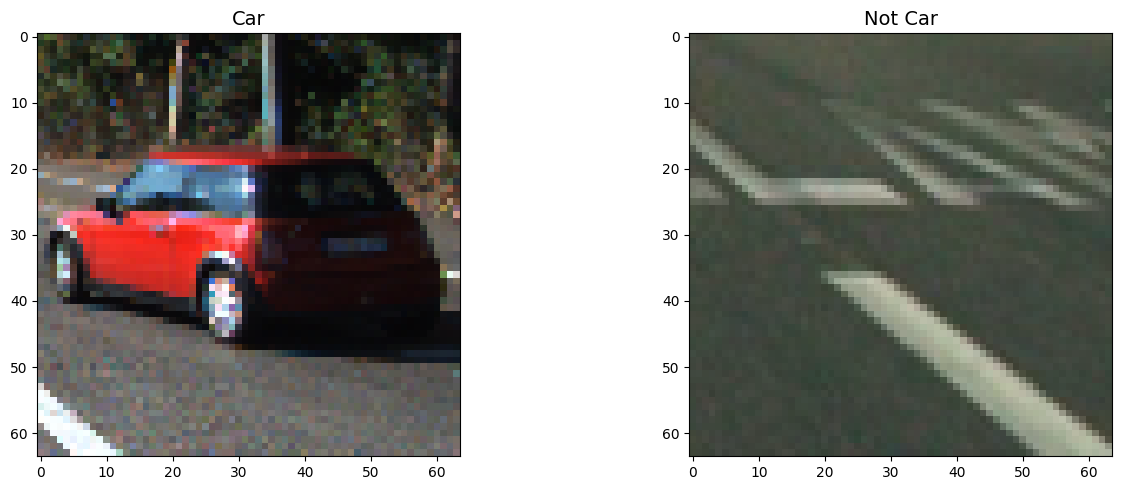

In [6]:
image_of_car = cv2.cvtColor(cv2.imread(car[np.random.randint(0, len(car))]), cv2.COLOR_BGR2RGB)
image_of_ncar = cv2.cvtColor(cv2.imread(n_car[np.random.randint(0, len(n_car))]), cv2.COLOR_BGR2RGB)

plot_multiple([image_of_car, image_of_ncar], title=['Car', 'Not Car'])

## Feature Extraction

### Hog Transformation

For this project, Hog Features are used. Before extracting the features,The images were transfered into the Yuv color space.

After, expirementing with various color spaces but finally settled to YUV.
* http://robotex.ing.ee/2012/01/pixel-classification-and-blob-detection/

As per the initial author, same skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). I finally settled on the following values:

* **orient = 9**
* **pix_per_cell = 8**
* **cell_per_block = 2**



In [7]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

In [8]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  block_norm ='L2',
                                  visualize=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       block_norm ='L2',
                       visualize=vis, feature_vector=feature_vec)
        return features

Helper Functions For Image Conversion in Various Spaces

In [10]:
def channel(img, ch):
    return img[:, :, ch]

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def rgb2lab(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2hls(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2hsv(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]

def rgb2yuv(img, ch=-1):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if ch < 0:
        return img
    else:
        return img[:, :, ch]


#### Find Center of the bin edges and Plot the Color Histogram for a Given Image

In [11]:
def Color_Histogram(image, nbins=32, bins_range=(0,255), resize=None):
    if(resize !=None):
        image= cv2.resize(image, resize)
    zero_channel= np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    first_channel= np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    second_channel= np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    return zero_channel,first_channel, second_channel


def Bin_Center(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

Text(0.5, 1.0, 'YUV colorspace')

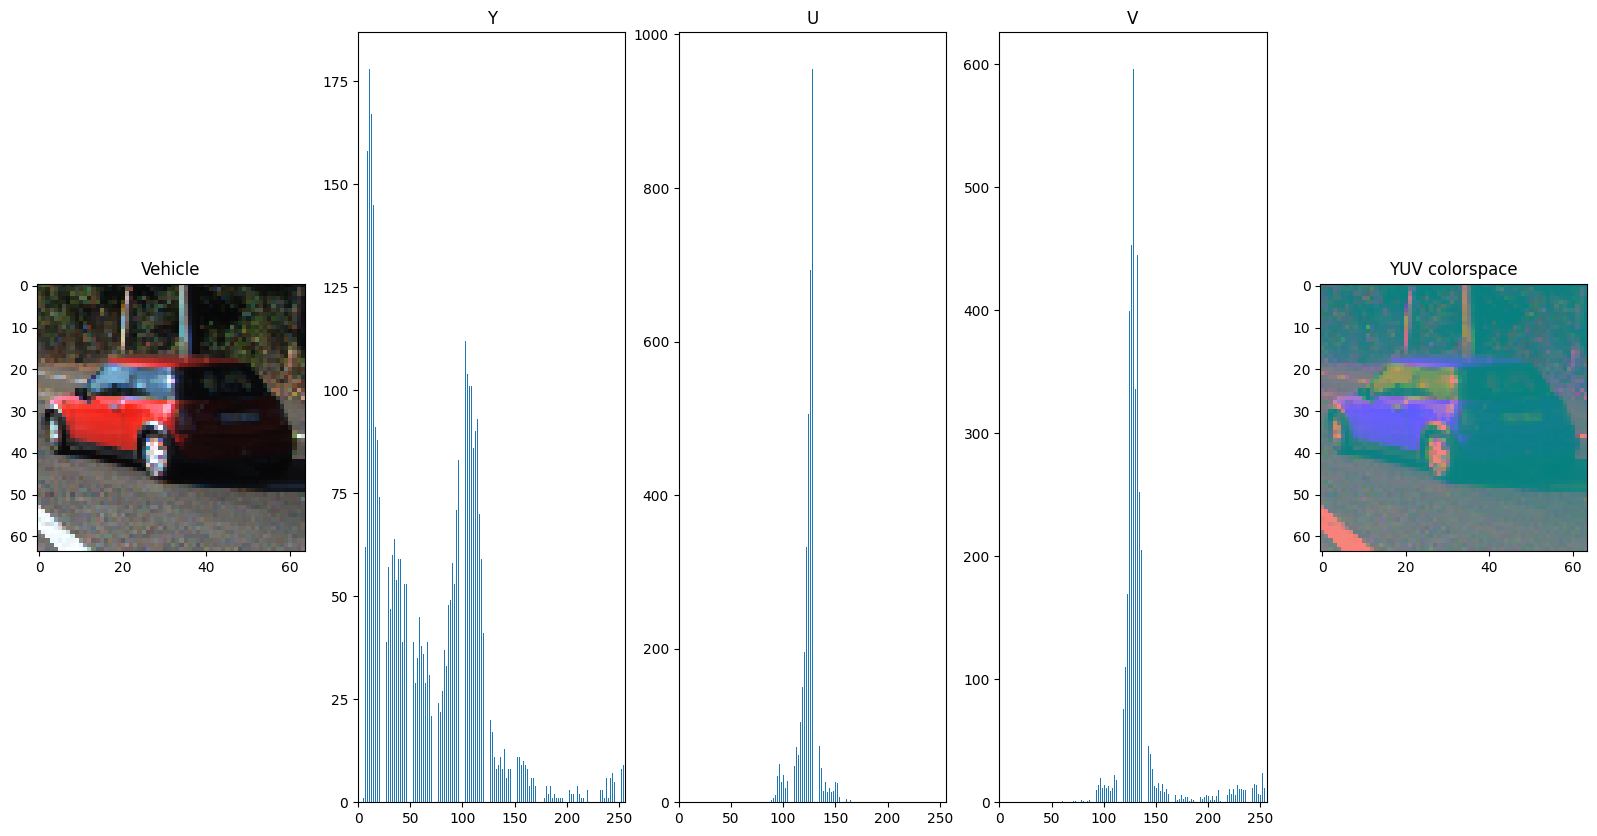

In [12]:
ch1,ch2,ch3 = Color_Histogram(rgb2yuv(image_of_car),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_car)
axes[0].set_title("Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("Y")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("U")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("V")
axes[4].imshow(rgb2yuv(image_of_car)) # Corrected by NuwanJ
axes[4].set_title("YUV colorspace")

Text(0.5, 1.0, 'YUV colorspace')

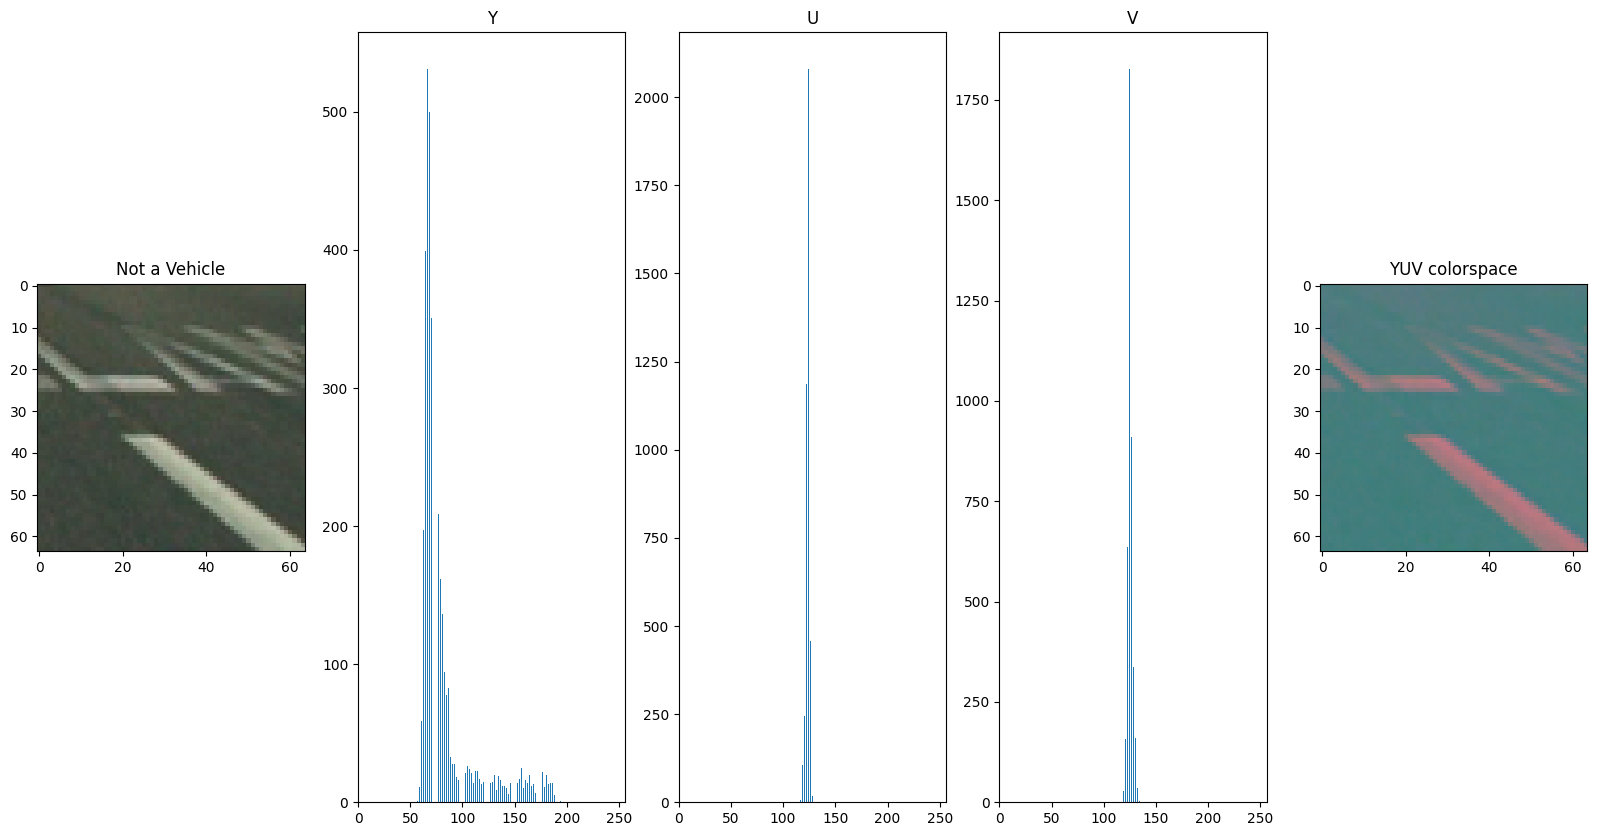

In [13]:
ch1,ch2,ch3 = Color_Histogram(rgb2yuv(image_of_ncar),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_ncar)
axes[0].set_title("Not a Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("Y")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("U")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("V")
axes[4].imshow(rgb2yuv(image_of_ncar)) # Corrected by NuwanJ
axes[4].set_title("YUV colorspace")

In [14]:
hog_features_y, hog_img_y = get_hog_features(img=rgb2yuv(image_of_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_u, hog_img_u = get_hog_features(img=rgb2yuv(image_of_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_v, hog_img_v = get_hog_features(img=rgb2yuv(image_of_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)

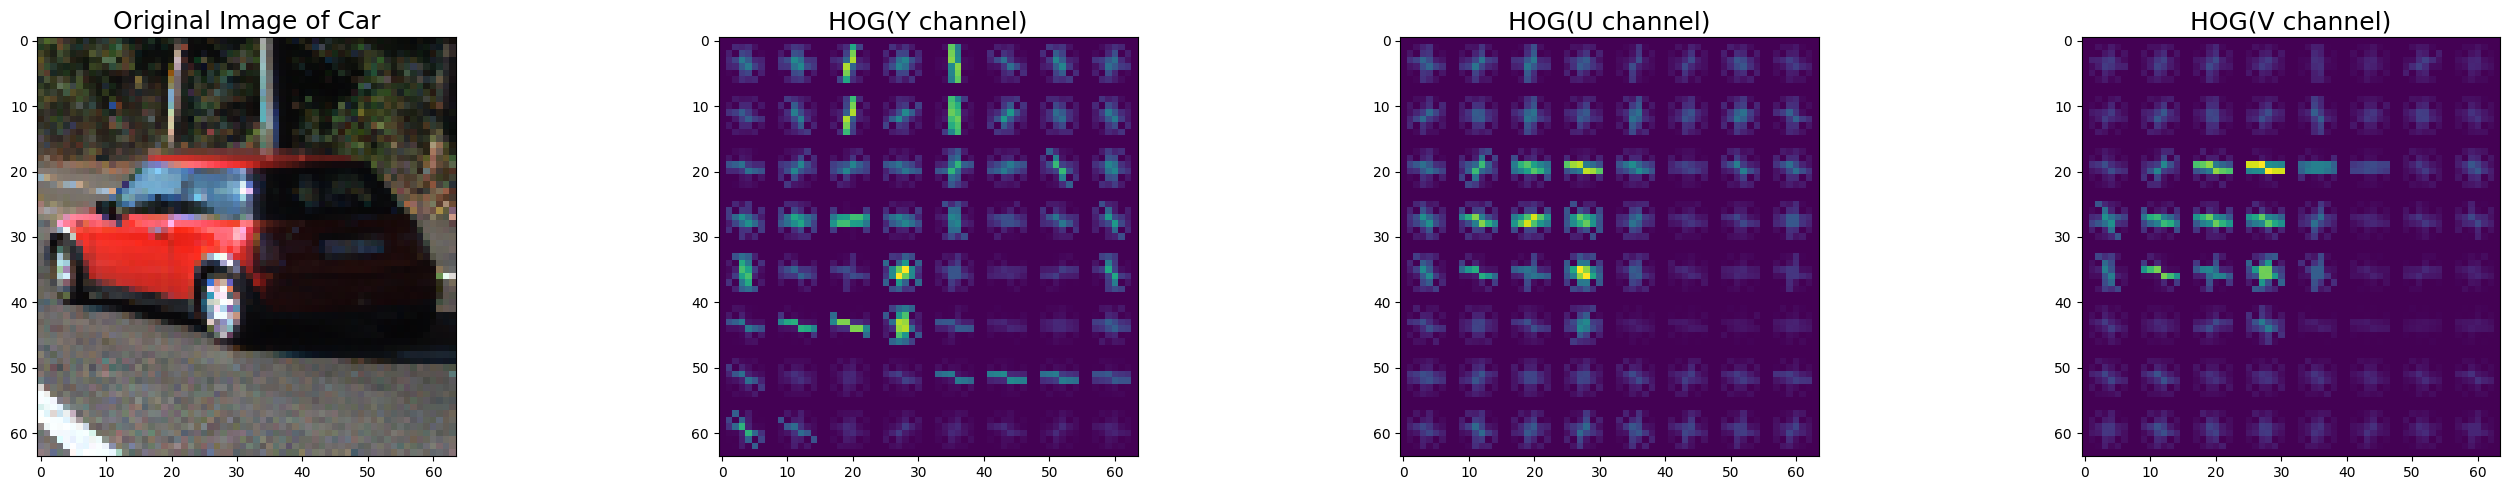

In [15]:
plot_multiple([image_of_car, hog_img_y, hog_img_u, hog_img_v], title=['Original Image of Car', 'HOG(Y channel)', 'HOG(U channel)', 'HOG(V channel)'], fontsize=18)

Text(0.5, 1.0, 'HLS colorspace')

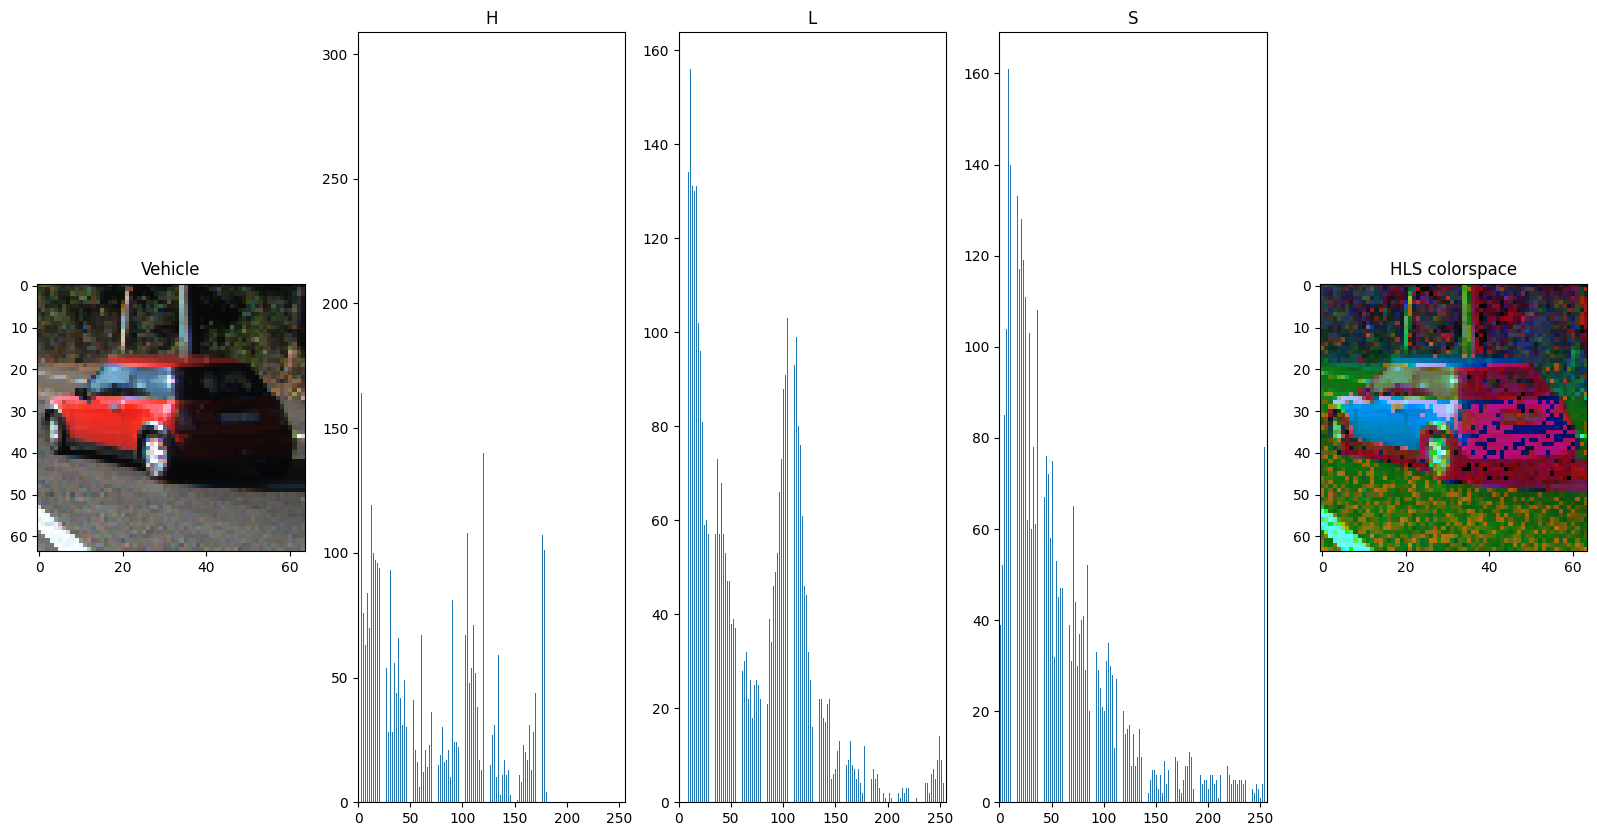

In [16]:
ch1,ch2,ch3 = Color_Histogram(rgb2hls(image_of_car),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_car)
axes[0].set_title("Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("H")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("L")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("S")
axes[4].imshow(rgb2hls(image_of_car))
axes[4].set_title("HLS colorspace")

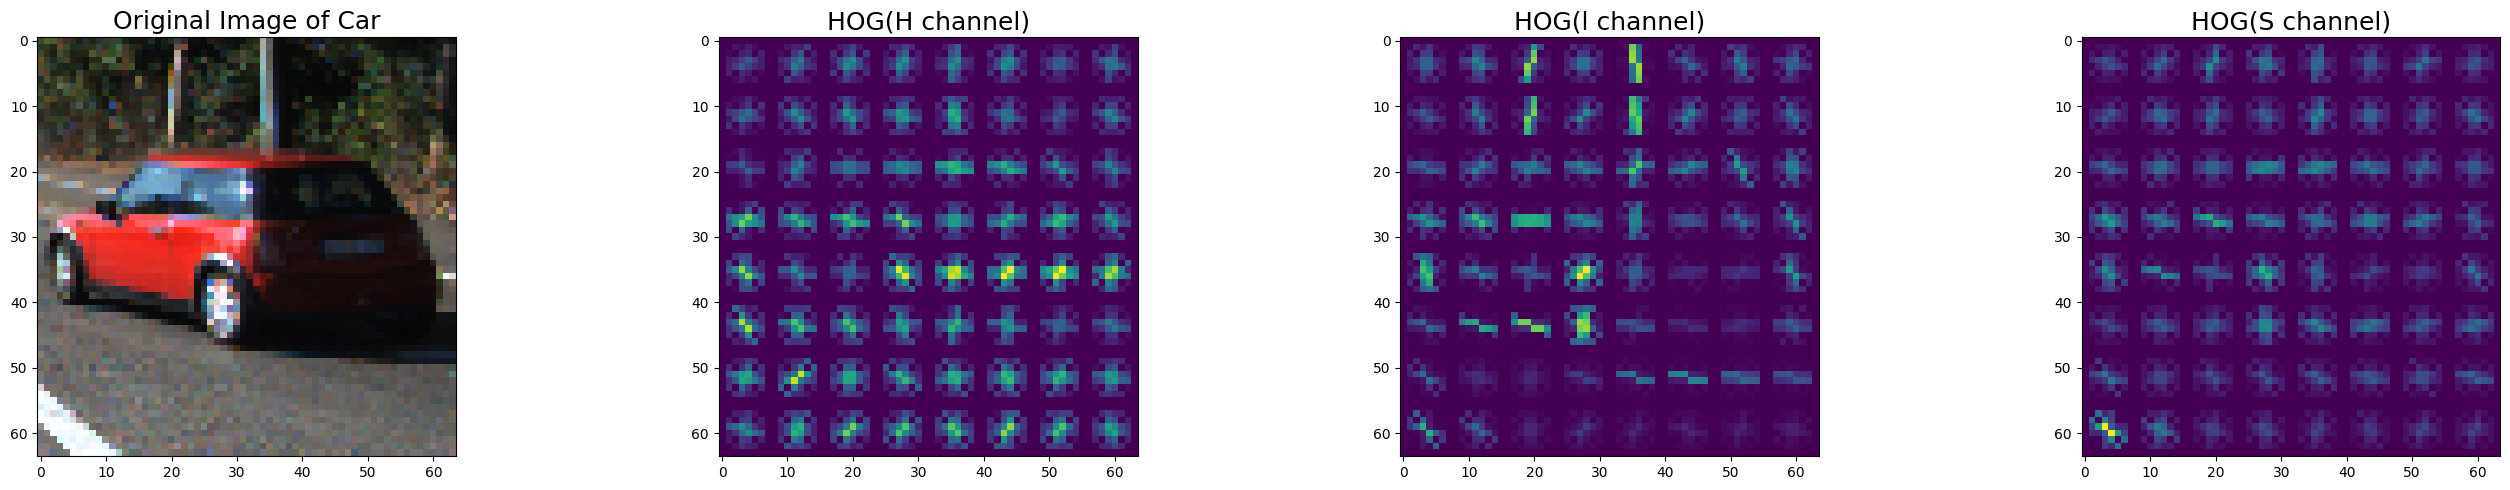

In [17]:
hog_features_h, hog_img_h = get_hog_features(img=rgb2hls(image_of_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_l, hog_img_l = get_hog_features(img=rgb2hls(image_of_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_s, hog_img_s = get_hog_features(img=rgb2hls(image_of_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
plot_multiple([image_of_car, hog_img_h, hog_img_l, hog_img_s], title=['Original Image of Car', 'HOG(H channel)', 'HOG(l channel)', 'HOG(S channel)'], fontsize=18)

Text(0.5, 1.0, 'LAB colorspace')

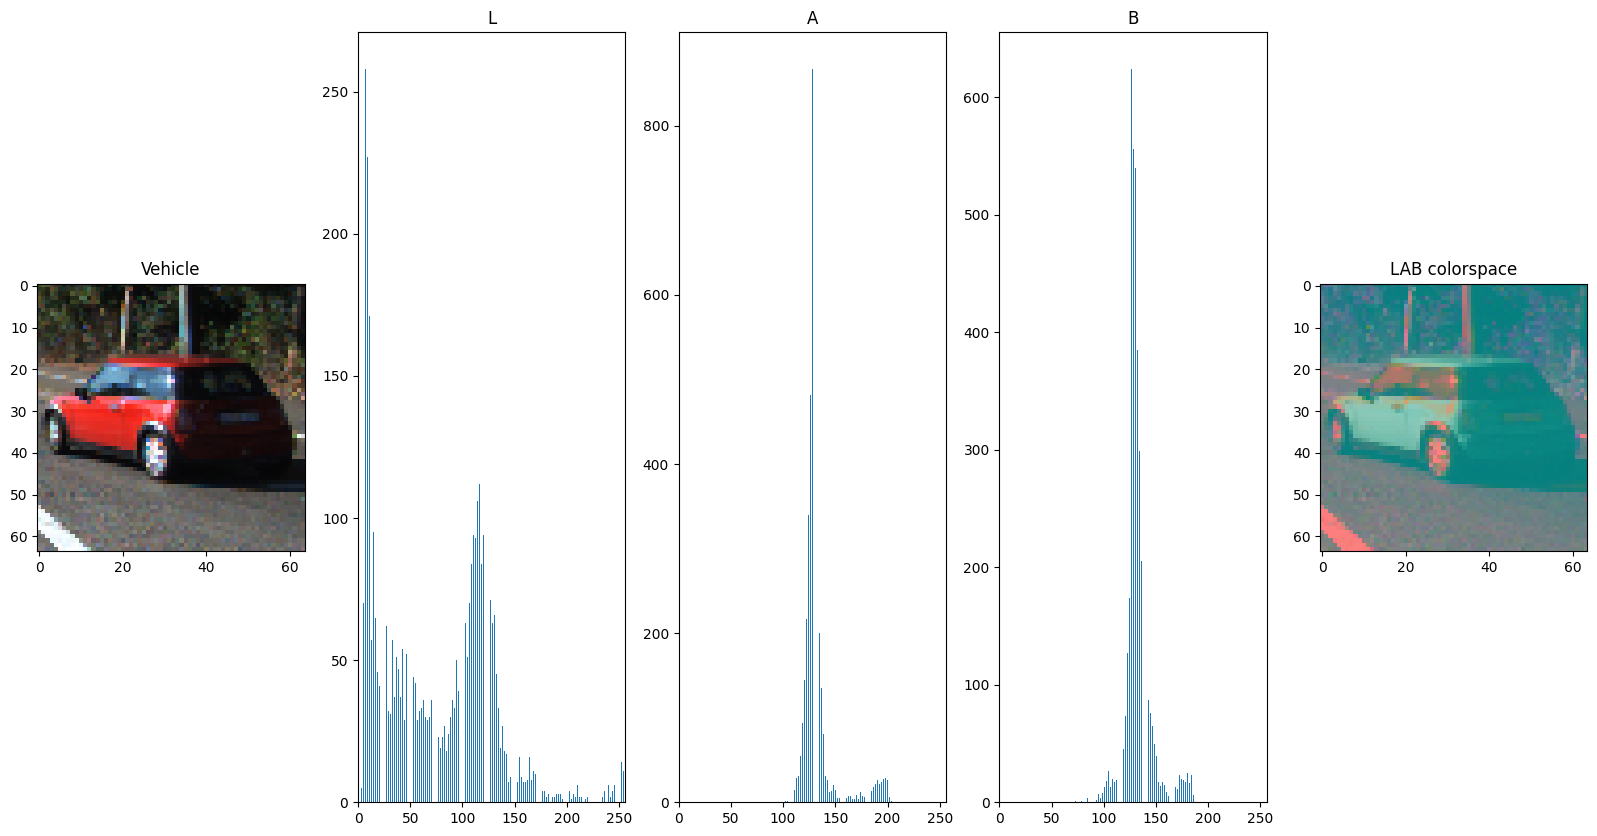

In [18]:
ch1,ch2,ch3 = Color_Histogram(rgb2lab(image_of_car),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_car)
axes[0].set_title("Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("L")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("A")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("B")
axes[4].imshow(rgb2lab(image_of_car))
axes[4].set_title("LAB colorspace")

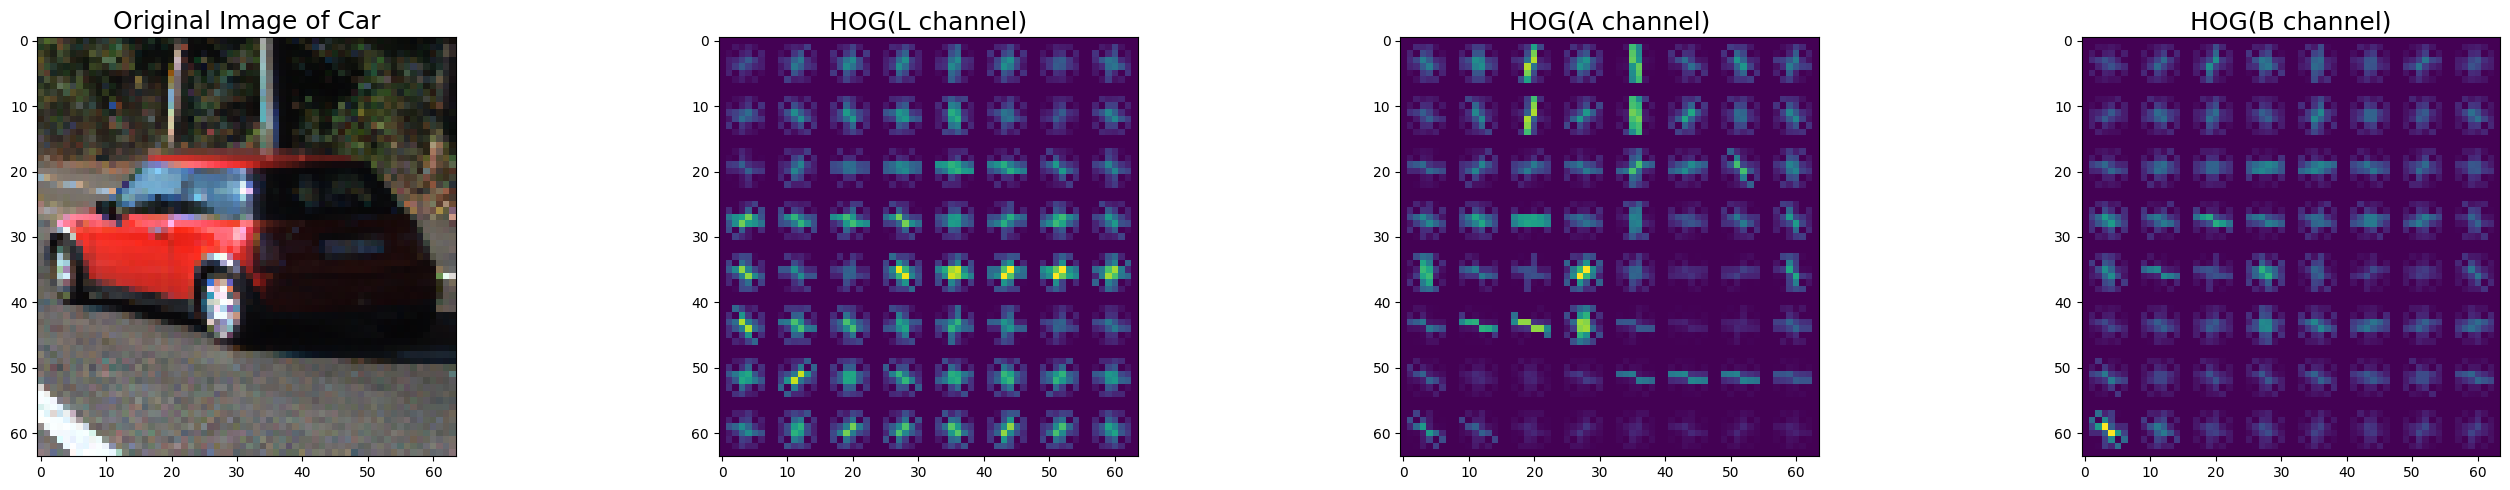

In [19]:
hog_features_l, hog_img_l = get_hog_features(img=rgb2lab(image_of_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_a, hog_img_a = get_hog_features(img=rgb2lab(image_of_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_b, hog_img_b = get_hog_features(img=rgb2lab(image_of_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
plot_multiple([image_of_car, hog_img_h, hog_img_l, hog_img_s], title=['Original Image of Car', 'HOG(L channel)', 'HOG(A channel)', 'HOG(B channel)'], fontsize=18)

Text(0.5, 1.0, 'HSV colorspace')

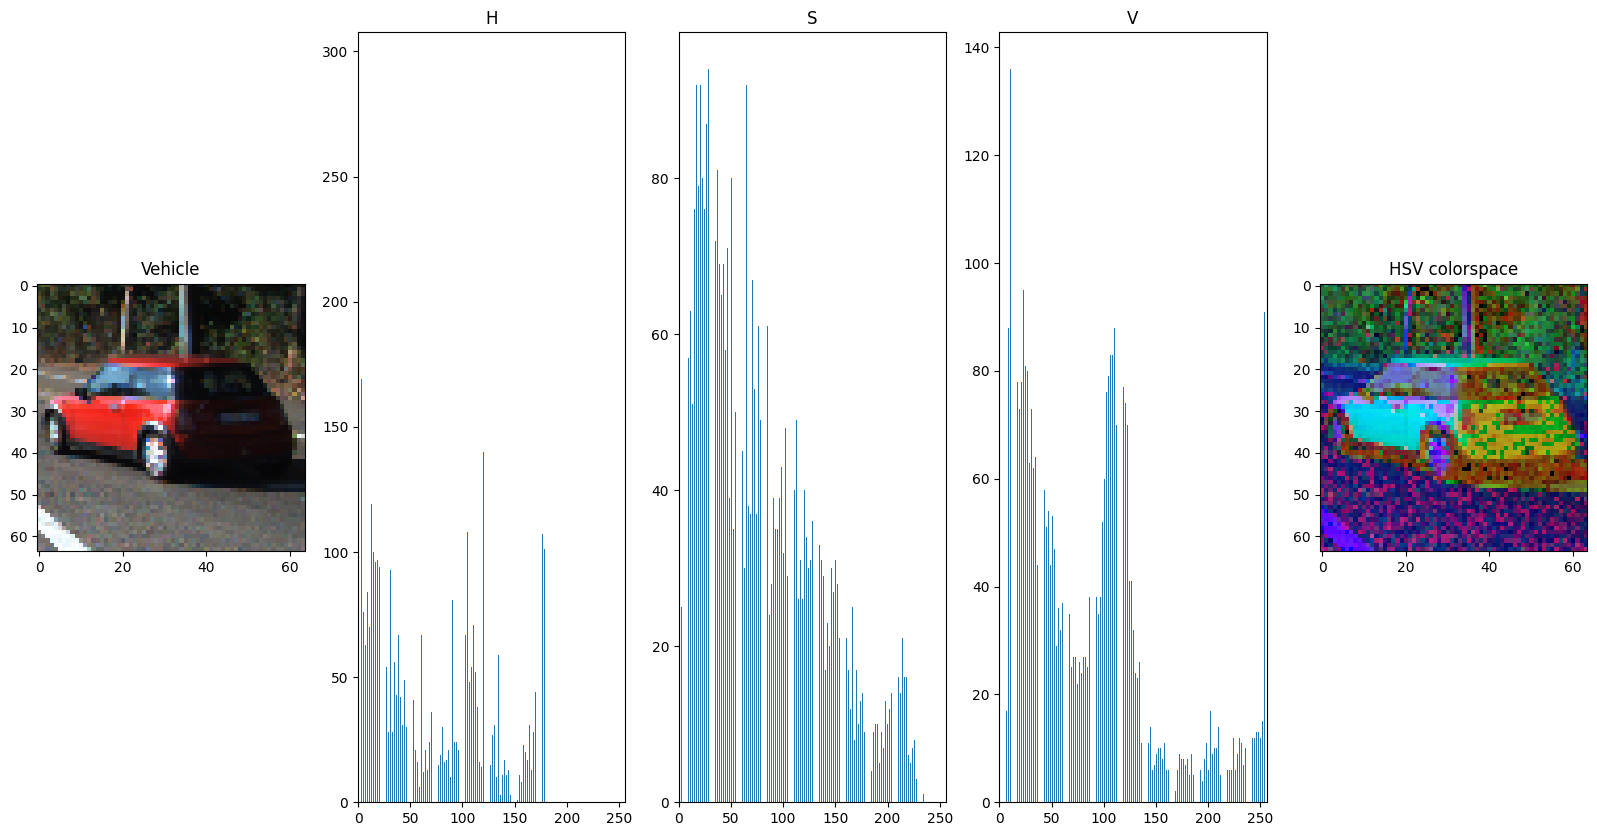

In [20]:
ch1,ch2,ch3 = Color_Histogram(rgb2hsv(image_of_car),128)
f, axes= plt.subplots(1,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)
center= Bin_Center(ch1)
axes[0].imshow(image_of_car)
axes[0].set_title("Vehicle")
axes[1].set_xlim(0,256)
axes[1].bar(center,ch1[0])
axes[1].set_title("H")
axes[2].set_xlim(0,256)
axes[2].bar(center,ch2[0])
axes[2].set_title("S")
axes[3].set_xlim(0,256)
axes[3].bar(center,ch3[0])
axes[3].set_title("V")
axes[4].imshow(rgb2hsv(image_of_car))
axes[4].set_title("HSV colorspace")

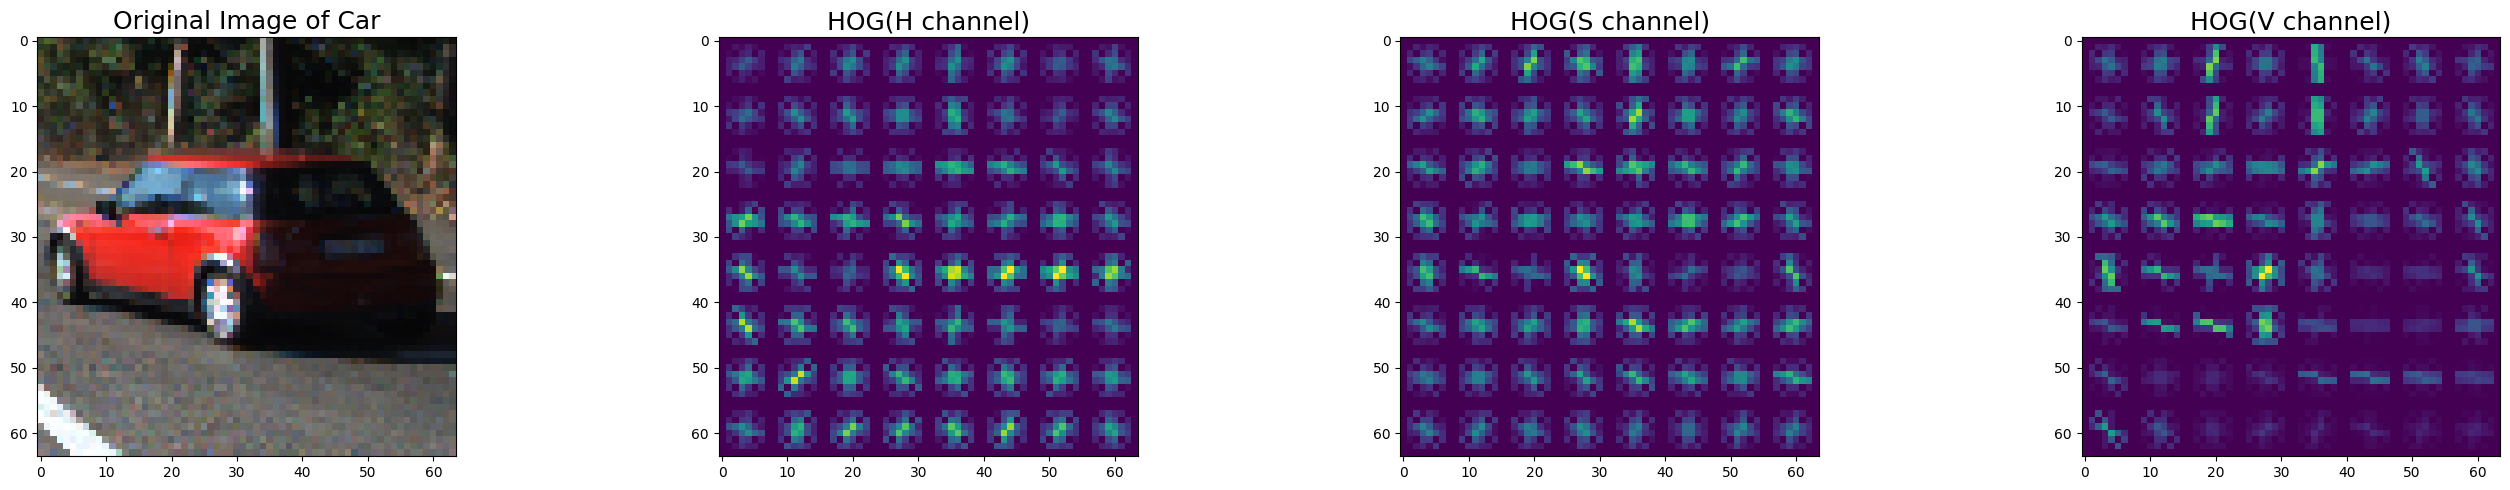

In [21]:
hog_features_h, hog_img_h = get_hog_features(img=rgb2hsv(image_of_car, ch=0), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_s, hog_img_s = get_hog_features(img=rgb2hsv(image_of_car, ch=1), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
hog_features_v, hog_img_v = get_hog_features(img=rgb2hsv(image_of_car, ch=2), orient = 16, pix_per_cell = 8, cell_per_block = 2, vis=True)
plot_multiple([image_of_car, hog_img_h, hog_img_s, hog_img_v], title=['Original Image of Car', 'HOG(H channel)', 'HOG(S channel)', 'HOG(V channel)'], fontsize=18)

In [23]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

## **Feature Extraction**

In [24]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



## Linear Support Vector Classifier (Linear SVC)
 1. The Linear SVM classifier using HOG and color was trained
 2. The disadvantage though is the computational complexity, i.e. in order to classify if the image belongs to one of two classes, the classifier should analyse its histogram, pixels and hog features

In [25]:
print(color_space,spatial_size,hist_bins,orient,pix_per_cell,cell_per_block,hog_channel,spatial_feat,hist_feat,hog_feat)
print('Get Car Features')
car_features = extract_features(car, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)


print('Get Non Car Features')
n_car_features = extract_features(n_car, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

print('Preparing Dataset')
# Create an array stack of feature vectors
X = np.vstack((car_features, n_car_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(n_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Added by NuwanJ
X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, test_size=0.25, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Added by NuwanJ
x_validate = X_scaler.transform(X_validate)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


YUV (32, 32) 32 9 8 2 ALL True True True
Get Car Features
Get Non Car Features
Preparing Dataset
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
11.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9941


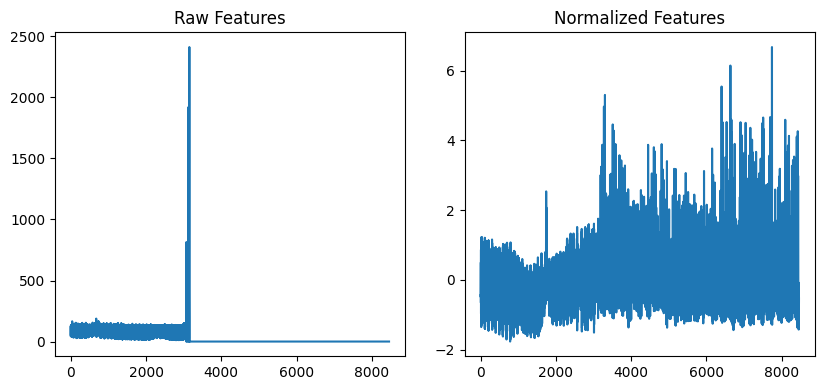

In [26]:
car_ind = np.random.randint(0, len(car))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(X_train[car_ind])
plt.title('Normalized Features')
fig.tight_layout()


In [27]:
parameters = [color_space ,orient, pix_per_cell, cell_per_block, hog_channel,spatial_size ,hist_bins,spatial_feat,hist_feat ,hog_feat, y_start_stop]


In [28]:
parameters

['YUV', 9, 8, 2, 'ALL', (32, 32), 32, True, True, True, [None, None]]

##Developemnt of ML Flow

This is a newly added code by NuwanJ

In [29]:
print("Training sets:\nx_train: {} \ny_train:{}".format(X_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} \ny_test:{}".format(X_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} \ny_validate: {}".format(X_validate.shape, y_validate.shape))

Training sets:
x_train: (13320, 8460) 
y_train:(13320,)

Testing sets:
x_test: (3552, 8460) 
y_test:(3552,)

Validation sets:
x_validate: (4440, 8460) 
y_validate: (4440,)


In [30]:
def train(sk_model, X_train, y_train):
    sk_model = sk_model.fit(X_train, y_train)
    # works only with some sklearn ML models such as LR
    train_acc = sk_model.score(X_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [31]:
def evaluate(sk_model, X_test, y_test):
    eval_acc = sk_model.score(X_test, y_test)
    preds = sk_model.predict(X_test)
    auc_score = roc_auc_score(y_test, preds)
    # you can also tell MLFlow to save the plots generated by matplotlib and
    # by seaborn. With this, you can look at each of the graphs
    # for each training run and do so in a highly organized manner.
    # You must first save these plots, which you do in the same directory.
    # Then, you must tell MLFlow to grab the artifacts to log them
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")
    roc_plot = RocCurveDisplay.from_estimator(sk_model, X_test, y_test)
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")
    print(classification_report(y_test, preds))

In [32]:
mlflow.set_experiment("scikit_learn_experiment")

2024/01/14 20:30:16 INFO mlflow.tracking.fluent: Experiment with name 'scikit_learn_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/933115954098587670', creation_time=1705264216074, experiment_id='933115954098587670', last_update_time=1705264216074, lifecycle_stage='active', name='scikit_learn_experiment', tags={}>

Train Accuracy: 100.000%
Auc Score: 99.404%
Eval Accuracy: 99.409%


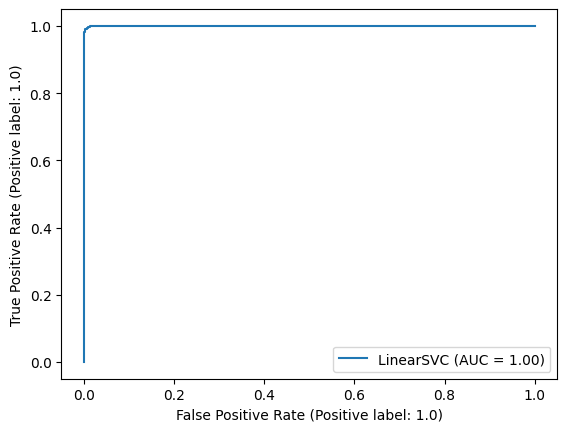

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1808
         1.0       1.00      0.99      0.99      1744

    accuracy                           0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552

Model run:  eeb1c117aca34e2dae246e25b9d9c27d


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


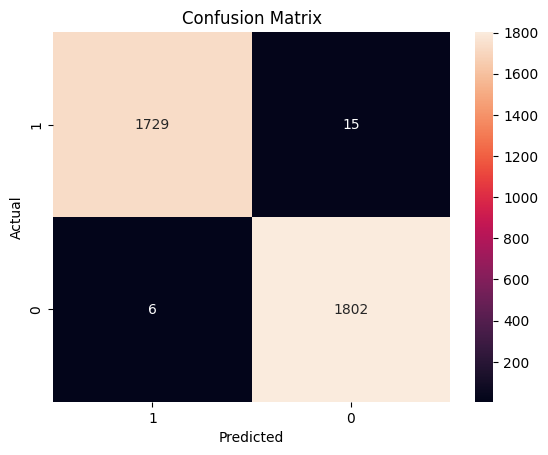

In [33]:
svc = LinearSVC()

with mlflow.start_run():
    train(svc, X_train, y_train)
    evaluate(svc, X_test, y_test)
    mlflow.sklearn.log_model(svc, "log_reg_model")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()

In [35]:
# loaded_model = mlflow.sklearn.load_model("runs:/YOUR_RUNID_HERE/log_reg_model")
loaded_model = mlflow.sklearn.load_model("runs:/eeb1c117aca34e2dae246e25b9d9c27d/log_reg_model")

In [36]:
loaded_model.score(X_test, y_test)

# Now you know how to load a model from a specific MLFlow run.

0.9940878378378378

In [ ]:
pip install azureml-mlflow

##Use MLflow with Azure Machine Learning for Local Training Run

https://pypi.org/project/azureml-core/

Special Note: Please comment out totally this Azure integrating codes to run the rest of the model. (As Azure account access for other are not allowed than me)

In [ ]:
pip install azureml-core

https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/track-and-monitor-experiments/using-mlflow/train-local/train-local.ipynb

In [ ]:
import azureml.core
from azureml.core import Workspace
print("SDK version:", azureml.core.VERSION)

SDK version: 1.54.0


In [ ]:
import os

# Loggded In with Student Licence and created a resource group to link this codeding with Azure
subscription_id = os.getenv("b4541b72-c7b6-4eae-a4f3-4ab06f5ffa9d", default="<my-subscription-id>")
resource_group = os.getenv("AvNEW", default="<my-resource-group>")
workspace_name = os.getenv("AV_Object_Detect", default="<my-workspace-name>")
workspace_region = os.getenv("East US 2 ", default="eastus2")

To connect with Mictrosoft Azure CLI (Azure Account is required to link the model artifacts to Azure ML Workspace. I have created Student account and created the workspace)

In [ ]:
from azureml.core import Workspace

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except:
    print("Workspace not accessible. Change your parameters or create a new workspace below")

Performing interactive authentication. Please follow the instructions on the terminal.


Interactive authentication successfully completed.
Workspace not accessible. Change your parameters or create a new workspace below


Set tracking URI

In [ ]:
experiment_name = "LocalTrain-with-mlflow-sample"
mlflow.set_experiment(experiment_name)

In [ ]:
ws = Workspace.from_config()

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

In [ ]:
ws.experiments[experiment_name]

## *Pickling the data for future loading*...

In [37]:
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["parameters"] = parameters
dist_pickle["scaler"] = X_scaler
pickle.dump(dist_pickle, open( "svc_pickle.p", "wb" ) )
print("The Parameters of the Classifier has been pickled ")

The Parameters of the Classifier has been pickled 


In [38]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
parameters = dist_pickle["parameters"]
X_scaler = dist_pickle["scaler"]
print('Classifier data has been loaded')

Classifier data has been loaded


## Feature Extraction

In [39]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



In [40]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #test_features = scaler.tr
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



In [41]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Object Detection with sliding-window and Hog-Subsampling technique

Use the trained classifier to search for vehicles in images. The test_images are too saved in Google drive and import to execute the object detection

<ipython-input-41-b832c442b6df>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
<ipython-input-41-b832c442b6df>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

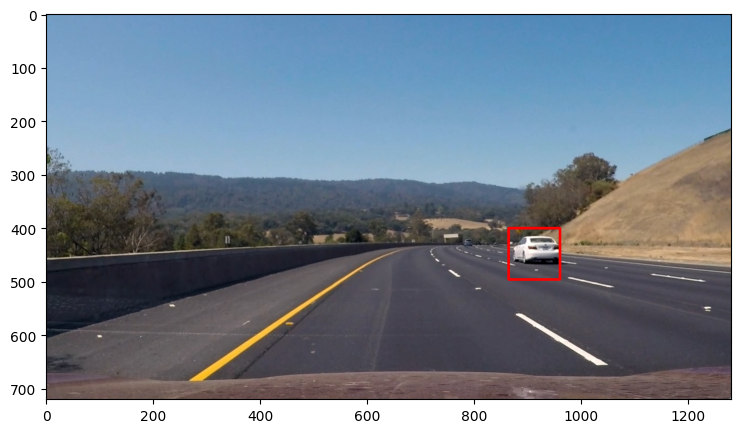

<ipython-input-41-b832c442b6df>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
<ipython-input-41-b832c442b6df>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

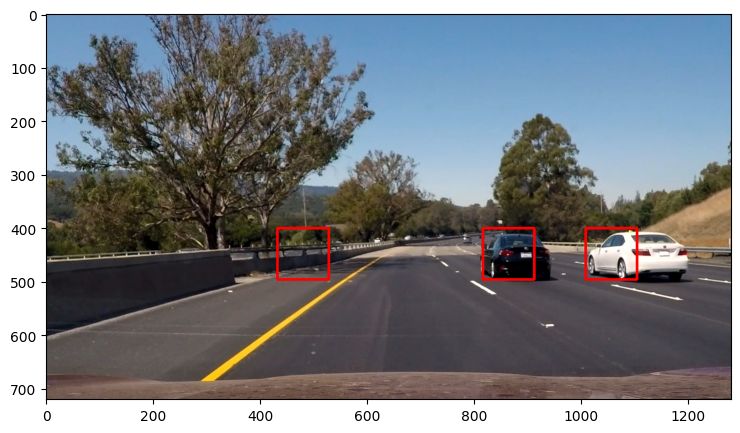

<ipython-input-41-b832c442b6df>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
<ipython-input-41-b832c442b6df>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

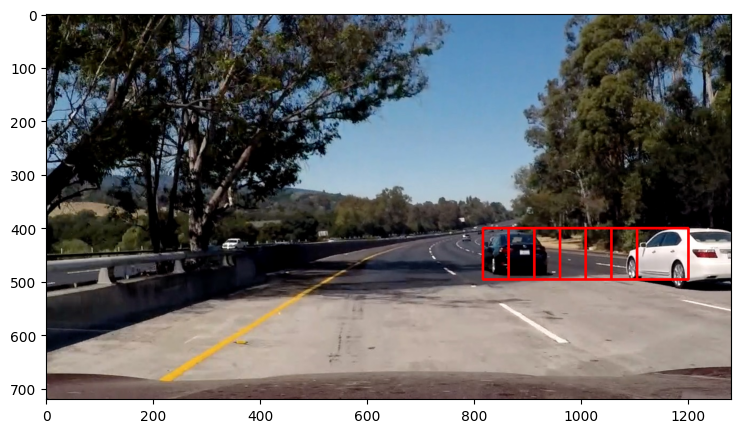

<ipython-input-41-b832c442b6df>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
<ipython-input-41-b832c442b6df>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

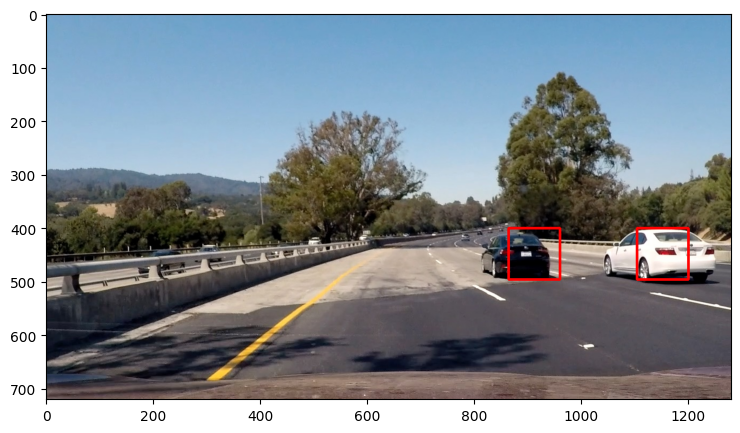

<ipython-input-41-b832c442b6df>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
<ipython-input-41-b832c442b6df>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

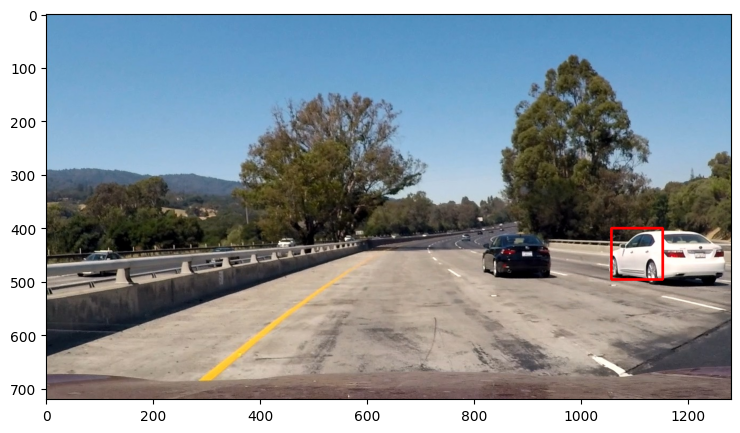

<ipython-input-41-b832c442b6df>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
<ipython-input-41-b832c442b6df>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

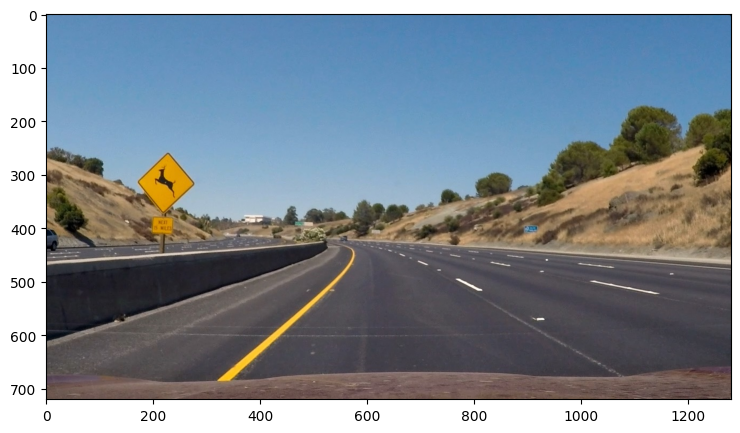

In [42]:
test = glob.glob('/content/drive/MyDrive/test_images/*.jpg')
for file in test:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    y_start_stop = [400, 650]
    windows = slide_window(image,
                           x_start_stop=[None, None],
                           y_start_stop=y_start_stop,
                           xy_window=(96, 96),
                           xy_overlap=(0.5, 0.5)
                          )

    hot_windows = search_windows(image, windows, svc, X_scaler,color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(image, hot_windows, color=(255, 0, 0), thick=4)
    plt.figure(figsize=(10, 5))
    plt.imshow(window_img)
    plt.show()

## Sliding Window
I had used Hog-Subsampling to detect the vehicles and draw boxes on them. I used different scale size to make the classifier classify, detect and draw boxes on them , irrespective of the distance from the camera.

The find_cars only has to extract hog features once, for each of a small set of predetermined window sizes (defined by a scale argument), and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor that impacts the window size. The scale factor can be set on different regions of the image (e.g. small near the horizon, larger in the center).

For our example are using a 64 x 64 base window. If we define cells per pixel as 8 x 8, then a scale of 1 would retain a window that's 8 x 8 cells (8 cells to cover 64 pixels in either direction). An overlap of each window can be defined in terms of the cell distance, using cells_per_step. This means that a cells_per_step = 2 would result in a search window overlap of 75% (2 is 25% of 8, so we move 25% each time, leaving 75% overlap with the previous window). Any value of scale that is larger or smaller than one will scale the base image accordingly, resulting in corresponding change in the number of cells per window. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [43]:
def find_cars(img, ystart=400, ystop=650, xstart=0, xstop=1280, scale=1.5, cells_per_step=2, svc=svc, X_scaler=X_scaler,
              color_space = 'YUV', orient = 9, pix_per_cell = 8, cell_per_block = 2, spatial_size = (32, 32), hist_bins = 32, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):

    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,xstart:xstop,:]

    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step


    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform((hog_features).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = xstart + np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                boxes.append(box)



    return boxes

In [44]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

## Notes on Pipe-Line:
#### 1.  Exponential Smoothing
What earned Poisson, Holts or Roberts a permanent place in the history of Mathematics is solving this with a succinct and elegant formula:

y^x=α⋅yx+(1−α)⋅y^x−1
If you stare at it just long enough, you will see that the expected value y^x is the sum of two products: α⋅yx and (1−α)⋅y^x−1. You can think of α (alpha) as a sort of a starting weight 0.9 in the above (problematic) example. It is called the smoothing factor or smoothing coefficient (depending on who wrote your text book).

So essentially we’ve got a weighted moving average with two weights: α and 1−α. The sum of α and 1−α is 1, so all is well.

Now let’s zoom in on the right side of the sum. Cleverly, 1−α is multiplied by the previous expected value y^x−1. Which, if you think about it, is the result of the same formula, which makes the expression recursive (and programmers love recursion), and if you were to write it all out on paper you would quickly see that (1−α) is multiplied by itself again and again all the way to beginning of the series, if there is one, infinitely otherwise. And this is why this method is called exponential.

This had been used on the heat_m. This helps to make box movements more smooth

https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/


#### 2. The effect of perspective the car appears small near the middle of the image and large near its edges. Therefore I searched in the four regions trying to take this into account.


#### 3. Plot Mode in the pipeline to vizualization purpose .

#### 4. I had to  searched on 4 different scales using YUV 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.






In [45]:
heat_m = np.zeros(shape=(720, 1280)).astype(np.int8)
def pipeline(image,plot = False):
    global heat_m

    boxes = []

    ystart_values = [400, 400, 400, 450]
    ystop_values = [500, 550, 600, 700]

    xstart = 0
    xstop = 1280
    cells_per_step = 2

    scale = 1
    ystart = ystart_values[0]
    ystop = ystop_values[0]
    box_1 = find_cars(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler)
    boxes.extend(box_1)

    scale = 1.4
    ystart = ystart_values[1]
    ystop = ystop_values[1]
    box_1_3 = find_cars(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler)
    boxes.extend(box_1_3)

    scale = 1.7

    ystart = ystart_values[2]
    ystop = ystop_values[2]
    box_1_7 = find_cars(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler)
    boxes.extend(box_1_7)

    scale = 2.5
    ystart = ystart_values[3]
    ystop = ystop_values[3]
    box_2_5 = find_cars(image, ystart, ystop, xstart, xstop, scale, cells_per_step, svc, X_scaler)
    boxes.extend(box_2_5)

    svm_guess = np.copy(image)
    for box in boxes:
        cv2.rectangle(svm_guess,box[0],box[1],(255,0,0),6)

    heat = np.zeros_like(image[:,:,0]).astype(np.int8)

    if not np.any(heat_m):
        heat_m = add_heat(heat, list(boxes))
    else:
        heat_m = np.uint8(0.7*add_heat(heat, list(boxes)) + (1-0.7)*heat_m)
    heatmap = apply_threshold(heat_m, 1)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    resize_heatmap = cv2.resize(np.dstack((heatmap, heatmap, heatmap))*255,(192,154))#Resize the image to fit the picture in the video
    x_offset = 50
    y_offset = 50
    draw_img[y_offset:y_offset+resize_heatmap.shape[0],x_offset:x_offset+resize_heatmap.shape[1]] = resize_heatmap



    if plot == True:
        return draw_img, svm_guess, heat_m, heatmap
    else:
        return draw_img

## Pipeline on the Test Images.

<ipython-input-43-ae2ea34b7d92>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)
<ipython-input-43-ae2ea34b7d92>:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

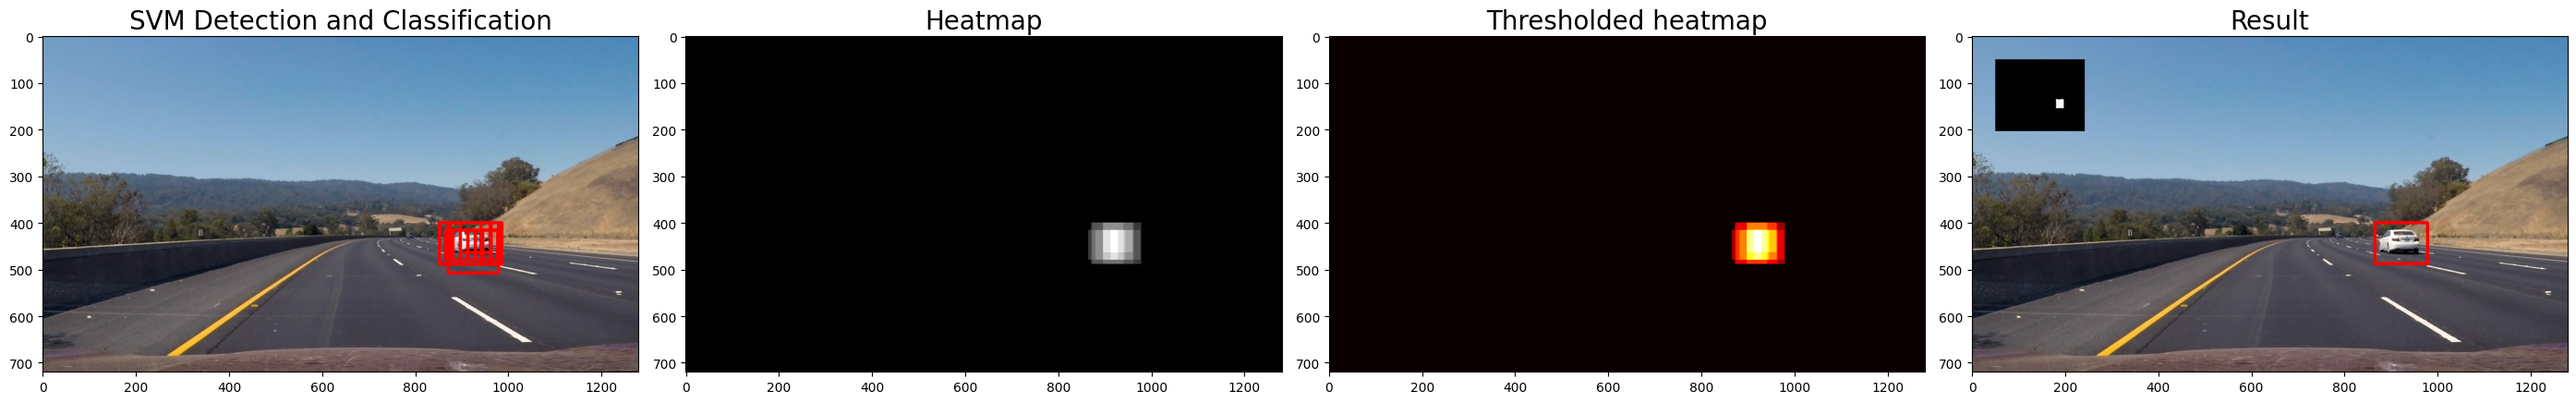

<ipython-input-43-ae2ea34b7d92>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)
<ipython-input-43-ae2ea34b7d92>:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

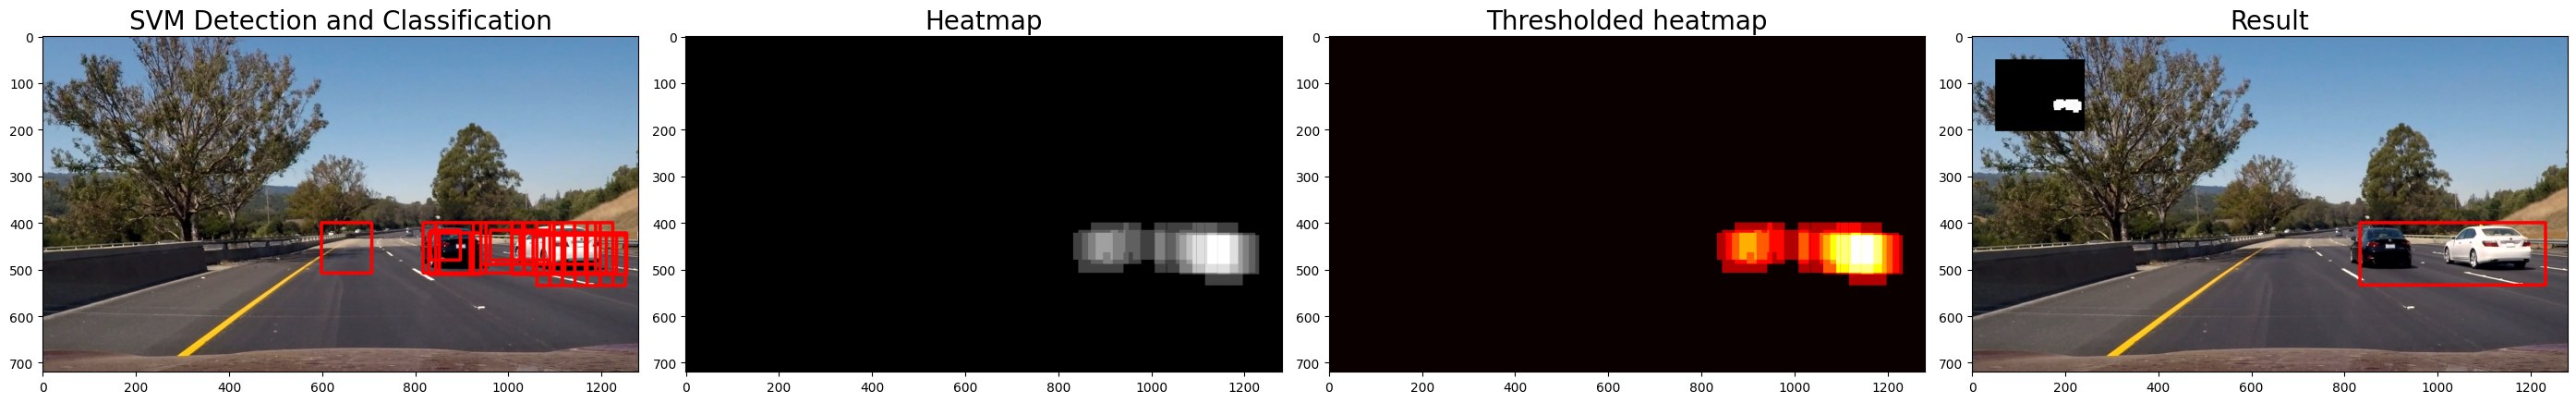

<ipython-input-43-ae2ea34b7d92>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)
<ipython-input-43-ae2ea34b7d92>:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

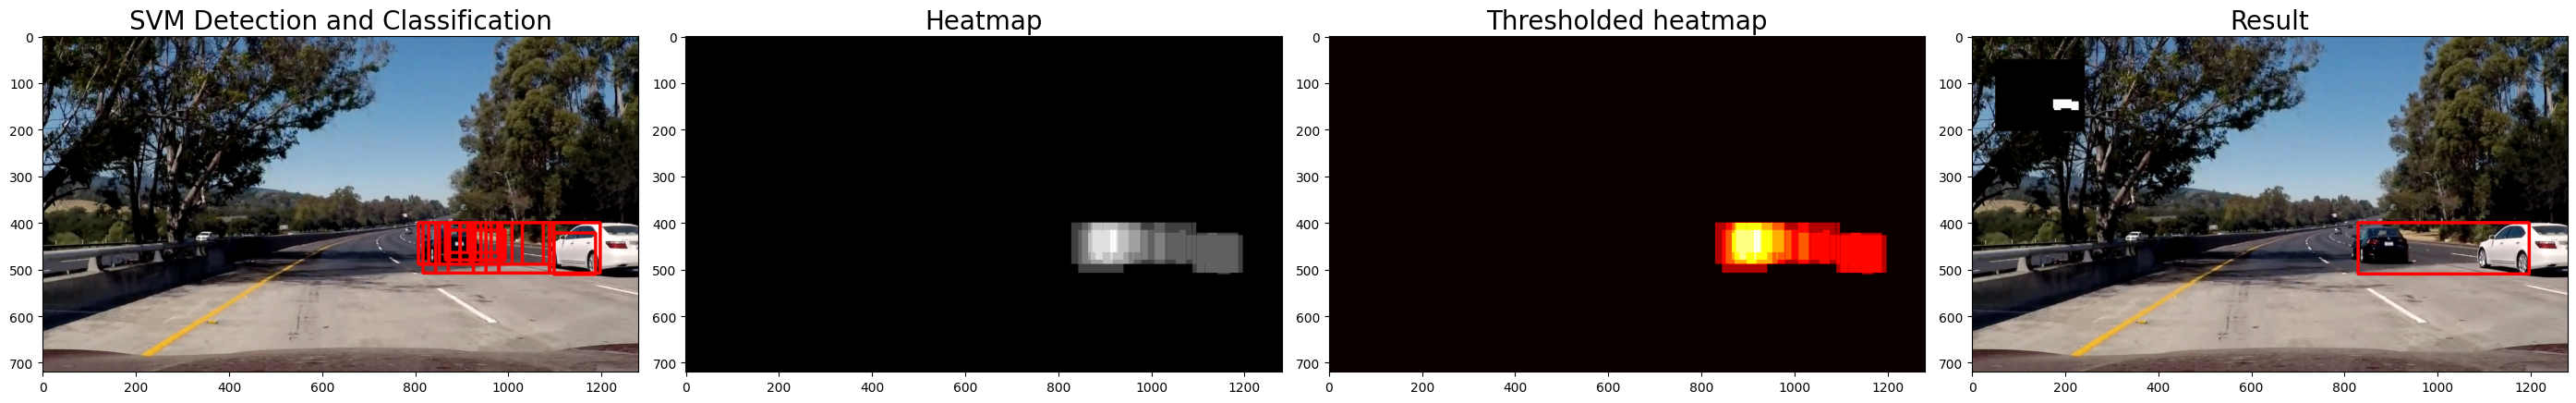

<ipython-input-43-ae2ea34b7d92>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)
<ipython-input-43-ae2ea34b7d92>:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

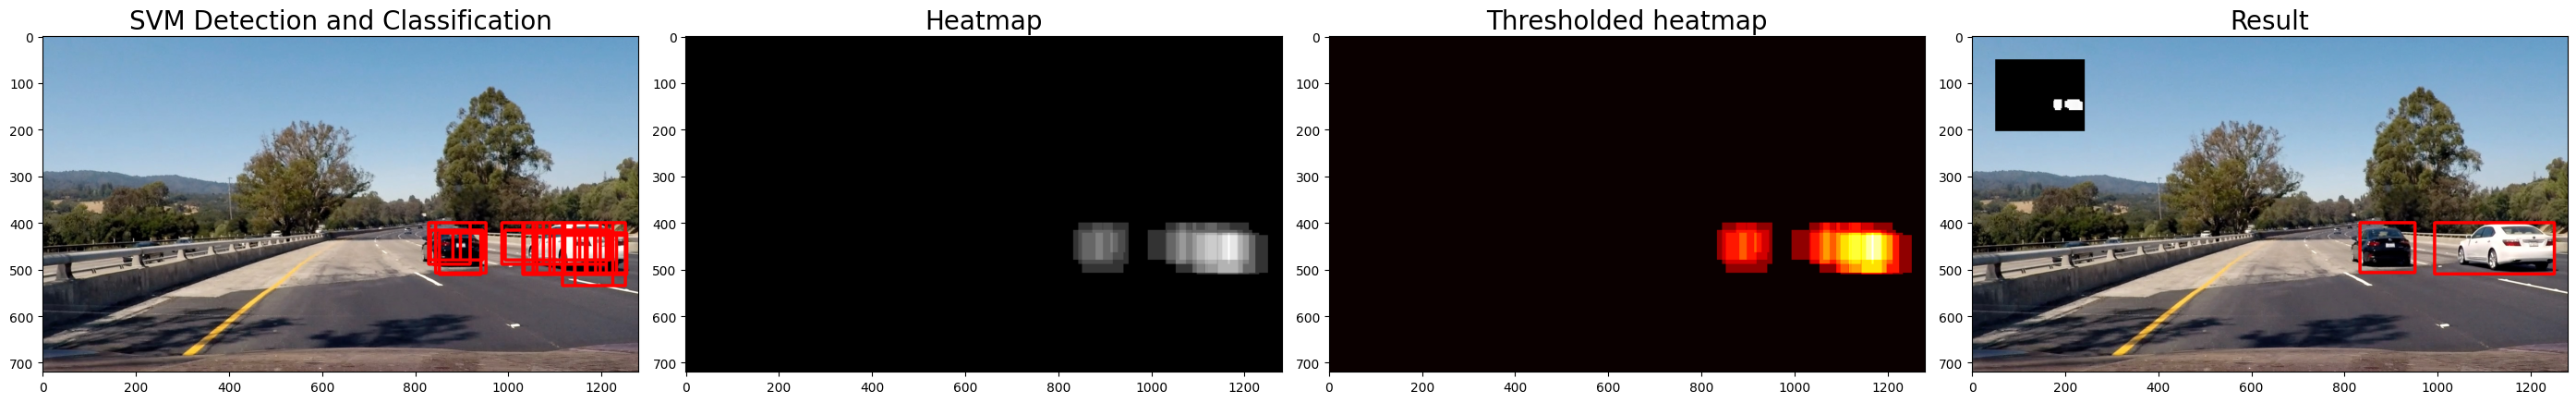

<ipython-input-43-ae2ea34b7d92>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)
<ipython-input-43-ae2ea34b7d92>:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

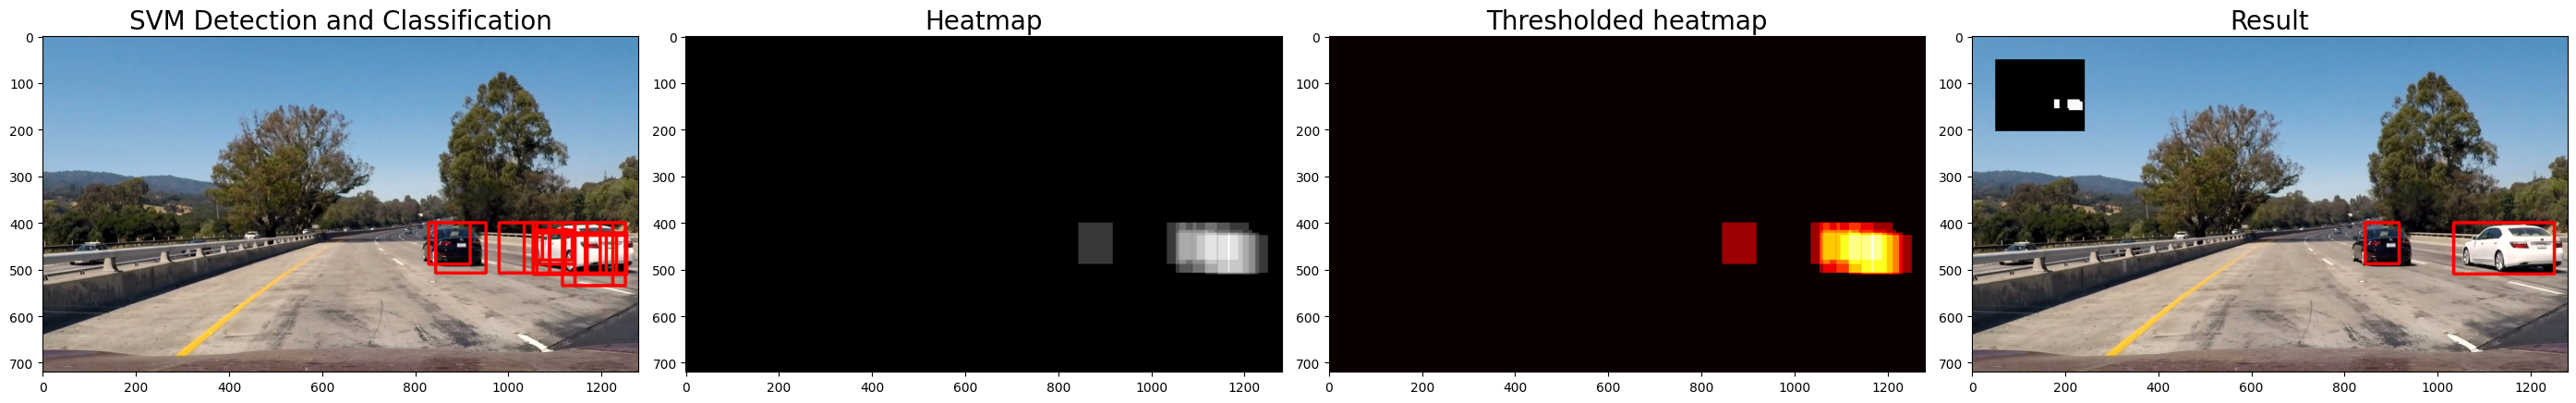

<ipython-input-43-ae2ea34b7d92>:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)
<ipython-input-43-ae2ea34b7d92>:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

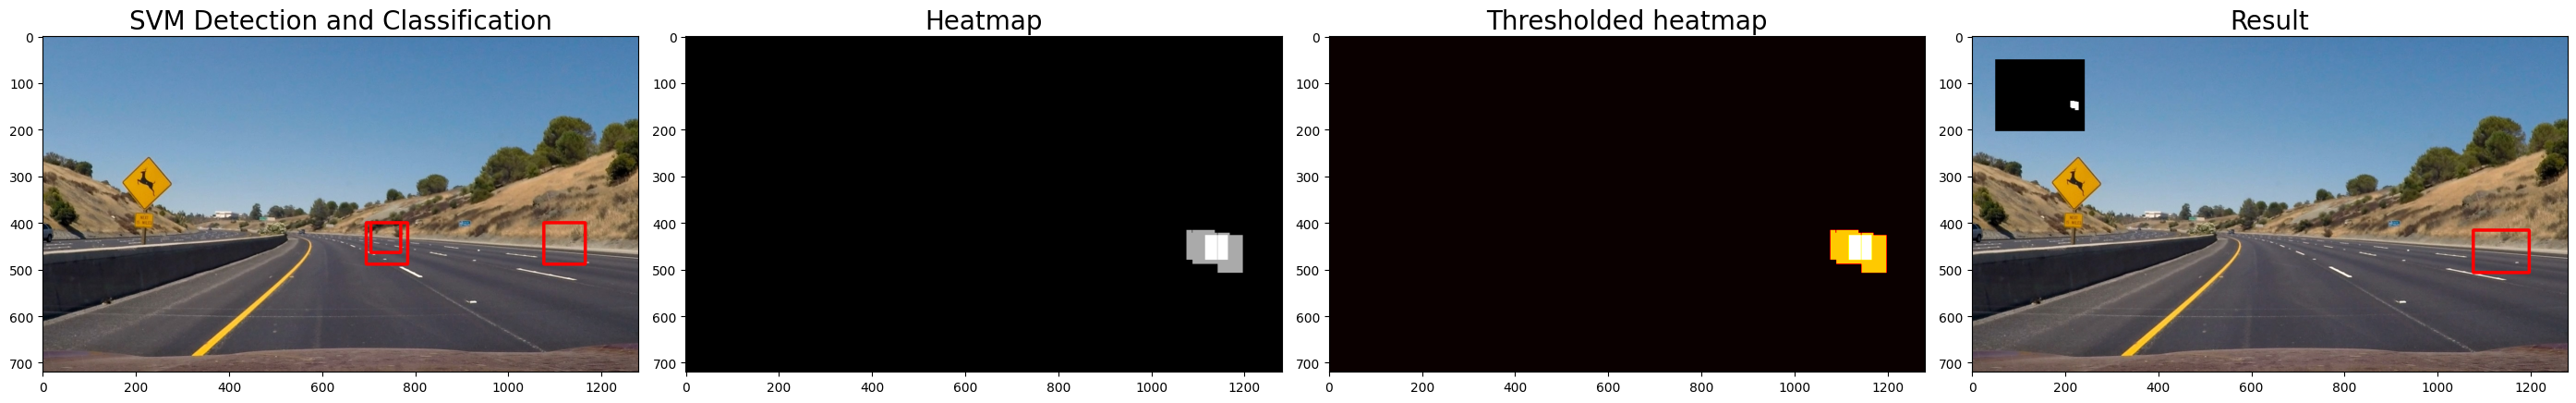

In [46]:
test_names = glob.glob('/content/drive/MyDrive/test_images/*.jpg')
test_set = []
for name in test_names:
    img = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    test_set.append(img)

test_set = np.array(test_set)

for i, test_sample in enumerate(test_set):
    res, raw_boxes, raw_heat, heat = pipeline(test_sample, plot = True)
    plot_multiple([raw_boxes, raw_heat, heat, res],
              cmaps=[None, 'gray', 'hot', None],
              title=['SVM Detection and Classification', 'Heatmap', 'Thresholded heatmap', 'Result'],
              fontsize=20)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("/content/drive/MyDrive/project_video.mp4")


white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ytop_draw = np.int(ytop*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  win_draw = np.int(window*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ytop_d

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Streaming output truncated to the last 5000 lines.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  win_draw = np.int(window*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ytop_draw = np.int(ytop*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  win_draw = np.int(window*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xbox_left = xstart + np.int(xleft*scale)

Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ytop_draw = np.int(ytop